In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import sys

sys.path.append("../")

### 0_Ready to Dataset


In [3]:
from pathlib import Path
import numpy as np
import cv2, os
from PIL import Image

#
from functools import reduce

In [4]:
def makeGraphNodesFromSegmentationMap(segmap):
    # Extract each class region and calculate center coordinates
    class_centers = {}
    class_indices = np.unique(segmentation_map)
    for class_index in class_indices:
        if class_index == 0:  # Skip background
            continue
        class_mask = np.where(segmentation_map == class_index, 1, 0).astype(np.uint8)
        contours, _ = cv2.findContours(class_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        center_list = []
        for contour in contours:
            moments = cv2.moments(contour)
            if moments["m00"] == 0:
                continue
            center = (int(moments["m10"] / moments["m00"]), int(moments["m01"] / moments["m00"]))
            center_list.append(center)
        class_centers[class_index] = center_list

    center = list(map(lambda x: [[x, *list(item)] for item in class_centers[x]], class_centers))
    points = np.array(reduce(lambda x, y: x + y, center))
    return points

In [87]:
for root, folder, files in os.walk("../data/error/"):
    if "Segmentation" in root:
        for _file in files:
            if _file.endswith(".png"):
                segmentation_map = np.array(Image.open(Path(root) / _file))
                points = makeGraphNodesFromSegmentationMap(segmentation_map)
                dst_path = Path(root.replace("Segmentation", "Graph"))
                dst_path.mkdir(parents=True, exist_ok=True)
                json.dump(points.tolist(), open(dst_path / _file.replace(".png", ".json"), "w"))

In [34]:
src_path = Path("../data/raw/WD/Segmentation/")
dst_path = Path("../data/raw/WD/Graph/")
dst_path.mkdir(parents=True, exist_ok=True)

In [35]:
for image_path in os.listdir(src_path):
    if image_path == ".DS_Store":
        continue
    #
    segmentation_map = np.array(Image.open(src_path / image_path))
    points = makeGraphNodesFromSegmentationMap(segmentation_map)
    #
    json.dump(points.tolist(), open(dst_path / image_path.replace(".png", ".json"), "w"))

### Make Graph Object


In [19]:
from src.makeGraph import make_graph

#
import networkx as nx
import matplotlib.pyplot as plt
import json

#
from torch_geometric.utils import from_networkx, to_networkx
import torch

#
import os

In [27]:
def make_graph_object_and_save_from_points(json_path):
    #
    points = np.array(json.load(open(json_path, "r")))
    graph_object = from_networkx(make_graph(x=points[:, 1], y=points[:, 2], threshold=70))
    #
    graph_object.x = torch.tensor(points[:, 0:1], dtype=torch.long)
    graph_object.pos = torch.tensor(points[:, 1:] / 512, dtype=torch.long)
    #
    dst_path = Path(str(json_path).replace("Graph", "GraphObject").replace(".json", ".pt"))
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(graph_object, dst_path)

In [29]:
base_path = Path("../data/raw/")
for root, folders, files in os.walk(base_path):
    if "Graph" in root:
        for _file in files:
            if _file == ".DS_Store":
                continue
            make_graph_object_and_save_from_points(Path(root) / _file)

In [21]:
#
built_graph = make_graph(x=points[:, 1], y=points[:, 2], threshold=70)

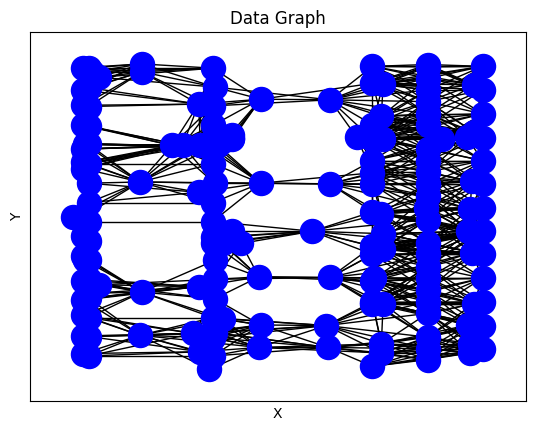

In [22]:
plt.figure()
plt.title("Data Graph")
plt.xlabel("X")
plt.ylabel("Y")
pos = {i: (points[i, 1], points[i, 2]) for i in range(len(points))}
nx.draw_networkx_nodes(built_graph, pos, node_color="b")
nx.draw_networkx_edges(built_graph, pos, edge_color="k")
plt.show()